In [36]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [3]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #print("input_X_forward.shape:",self.input_X_forward.shape)
        #print("dA.shape:",dA.shape)
        
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)
        
        # 更新
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [4]:
class Sigmoid:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _func_diff(self, X):
        return (1 - self._func(X)) * self._func(X)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [5]:
class Tanh:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.tanh(X)
    
    def _func_diff(self, X):
        return 1 - (self._func(X))**2
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [6]:
class softmax:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
        self.pred = 0
    
    def _func(self, X):
        X = X - np.max(X)
        tmp = np.exp(X)
        denominator = np.sum(tmp, axis=1)
        output = tmp / denominator[:, np.newaxis]
        return output
    
    def _func_diff(self, X):
        return X
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        self.pred = A
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = self.pred - dA
        
        return dZ

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [8]:
class ReLU:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.maximum(0, X)
    
    def _func_diff(self, X):
        return np.where( x > 0, 1, 0)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [9]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [10]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

In [11]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #dA, dWを更新＆保存
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

In [12]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.B = layer.B - self.lr * layer.B_feedback    
        layer.W = layer.W - self.lr * layer.W_feedback
        
        return layer

###### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [13]:
class SimpleConv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, f_w, f_b, optimizer):
        DIM = 1
        
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.f_hight = len(f_w)
        self.n_input_hight = n_input_hight
        #self.n_input_width = n_input_width
        self.W = f_w[:, np.newaxis]
        self.B = f_b[:, np.newaxis]
        self.dZ = 0
        self.dA = 0
        self.dB = 0
        print("N_input:{} F_hight:{}".format(self.n_input_hight, self.f_hight))
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        #self.n_output_width = self.n_input_width - f_width +1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros([self.n_output_hight, DIM])
        self.W_feedback = np.zeros([self.f_hight, DIM])
        self.B_feedback = 0
        self.Z_feedback = np.zeros([self.n_input_hight, DIM])
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        
        self.input_X_forward = X
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            
            X_seg = X[h1:h2]
            self.output_X_forward[h] = np.dot(X_seg, self.W) + self.B
        
        return self.output_X_forward
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #Wについて
        dA = dA[:,np.newaxis]
        for i in range(self.f_hight):
            X_seg = self.input_X_forward[i : (i + self.n_output_hight)]
            X_seg = X_seg[:,np.newaxis]
            self.W_feedback[i] = np.dot(X_seg.T, dA)
        
        #Bについて
        self.B_feedback = np.sum(dA, axis=0)
        
        #Zについて
        #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
        dA_padding = np.zeros([self.f_hight-1, 1])
        dA = np.concatenate((dA, dA_padding), axis=0)
        dA = np.concatenate((dA_padding, dA), axis=0)
        for h in range(self.n_input_hight):
            h1 = h
            h2 = h + self.f_hight
            dA_seg = dA[h1:h2]
            #並列計算工夫
            dA_seg = np.fliplr(dA_seg.T).T
            self.Z_feedback[h] = np.dot(dA_seg.T, self.W)
            #print("h:{} \n dA_seg:{} \n W:{}".format(h, dA_seg, self.W))

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

###### 【問題2】1次元畳み込み後の出力サイズの計算

In [14]:
def cal_output_size(n_feature_in, n_pading, n_filter, stride):
    return (n_feature_in + n_pading * 2 + n_filter) / stride

###### 【問題3】小さな配列での1次元畳み込み層の実験

In [15]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [16]:
#initializer = SimpleInitializer()
optimizer = SGD(0.001)

In [17]:
scv = SimpleConv1d(len(x), w, b, optimizer)

N_input:4 F_hight:3


In [18]:
scv.forward(x)

array([[35.],
       [50.]])

In [37]:
delta_a = np.array([10, 20])

In [38]:
scv.backward(delta_a)

array([[ 29.5],
       [108.2],
       [167.3],
       [137.8]])

In [39]:
print("delta_b:",scv.B_feedback)
print("delta_w:",scv.W_feedback)
print("delta_x:",scv.Z_feedback)

delta_b: [30]
delta_w: [[ 50.]
 [ 80.]
 [110.]]
delta_x: [[ 29.5]
 [108.2]
 [167.3]
 [137.8]]


##### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。
紙やホワイトボードを使い計算グラフを書きながら考えてください。
例えば以下のようなx, w, bがあった場合は

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。  
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。  
b = np.array([1, 2, 3]) # （出力チャンネル数）  
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。  

In [40]:
class Conv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.f_hight = f_w.shape[2]
        self.n_input_hight = n_input_hight
        #self.n_input_width = n_input_width
        self.W = f_w
        self.B = f_b
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        
        self.input_X_forward = X
        #for output_ch in range(self.W.shape[0]):
        A = np.zeros((self.n_output_hight, self.W.shape[0]))
        #self.input_X_forward = np.zeros((self.n_output_hight, X.shape[0], self.f_hight))
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight   
            X_seg = X[:, h1:h2]
            tmp = np.sum(X_seg * self.W, axis=1)
            A[h] = np.sum(tmp, axis=1)

        B = self.B[0]
        output = (A + B).T
        
        #print("output.shape:",output.shape)
        return output
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #Wについて
        #Row = 入力数＊出力数, Col = 出力の特徴量数　の入力X,誤差dLを作る 
        X = np.tile(self.input_X_forward, (dA.shape[0] ,1))
        dL = np.zeros((X.shape[0], dA.shape[1]))
        
        for i in range(dA.shape[0]):
            o1 = i
            o2 = i + self.input_X_forward.shape[0]
            dL[o1:o2] = np.tile(dA[i], (self.input_X_forward.shape[0] ,1))
        
        #入力の特徴量数 - 出力の特徴量数 +1
        loop = self.input_X_forward.shape[1] - dA.shape[1] + 1
        dW_tmp = np.zeros((X.shape[0], loop))
        for i in range(loop):
            i1 = i
            i2 = i + dA.shape[1]
            dX_seg = X[:, i1:i2]
            dW_tmp[:,i] = np.sum(dL * dX_seg, axis=1)
        
        #計算結果をフィルタサイズに整形
        for i in range(self.W.shape[0]):
            o1 = i
            o2 = i + self.W.shape[1]
            self.W_feedback[i] = dW_tmp[o1:o2]
        
        #Bについて
        dB = np.sum(dA, axis=1)
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        
        #Zについて Output数回す
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(dA.shape[0]):
            #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
            dA_padding = np.zeros([1, self.f_hight-1])
            dA_tmp = dA[i][np.newaxis,:]
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=1)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=1)
            dA_tmp = np.tile(dA_tmp, (self.input_X_forward.shape[0] ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,h1:h2]
                #並列計算工夫
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,h] = np.sum(dA_seg * self.W[i], axis=1)
                
            self.Z_feedback += dZ_seg #出力数分足し算

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

In [41]:
X = np.array([[1,2,3,4],[2,3,4,5]])
W = np.ones((3,2,3))
B = np.array([[[1,2,3], [1,2,3]]])

In [42]:
c = Conv1d(X.shape[1], W, B, None, optimizer)

In [43]:
c.forward(X)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [44]:
dA = np.array([[2,4],[4,8],[6,12]])

In [45]:
c.backward(dA)

array([[12, 36, 36, 24],
       [12, 36, 36, 24]])

###### 【問題5】学習・推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えて学習と推定を行ってください。出力層だけは全結合層をそのまま使ってください。
チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、平滑化を行います。平滑化はNumPyのreshapeが使用できます。
numpy.reshape — NumPy v1.15 Manual
画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [46]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier():
    """
    ディープニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]
        #self.activation_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.affine_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.n_layer = self.dnn_design.get('total_layer')
        
        #各インスタンスを生成
        #initializerインスタンス
        
    def _crossentropy(self, y_pred, y):
        #クロスエントロピーを計算する
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        #add_layerでセットしたlayer情報を全てクリアする
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        #lossの記録用の配列を用意
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                #Forwardの計算
                for layer in range(self.n_layer):
                    #X = self.affine_func[layer].forward(X)
                    #X = self.activation_func[layer].forward(X)
                    X = self.layer_instance[layer].forward(X)
                
                #Loss計算
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                #Backwardの計算
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    #dz = self.activation_func[layer].backward(dz)
                    #dz = self.affine_func[layer].backward(dz)
                    dz = self.layer_instance[layer].backward(dz)
                
                loop_count += 1
                
            #Epoch毎のLoss計算結果表示
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)  
            X = self.layer_instance[layer].forward(X)
        
        return X

In [47]:
class Flatten():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        self.inout_X_shape = X.shape
        return X.reshape(-1)[np.newaxis,:]
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

In [48]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(3000, 784)
(57000, 784)


In [49]:
CNN = ScratchDeepNeuralNetrowkClassifier(1, 1)

In [54]:
#CNN Filter(重み、バイアス)
f_w = np.ones((3,1,28))
f_b = np.array([[[1,1,1]]])

In [55]:
#初期化、更新インスタンスを作る
optimizer = SGD(0.01)
initializer = XavierInitializer()

In [56]:
#DNNデザイン
CNN.add_layer(Conv1d(x_train.shape[1], f_w, f_b, initializer, optimizer))
CNN.add_layer(Flatten())
CNN.add_layer(FC(f_w.shape[0] * (x_train.shape[1] - f_w.shape[2] + 1), 100, initializer, optimizer))
CNN.add_layer(Sigmoid())
CNN.add_layer(FC(100, 10, initializer, optimizer))
CNN.add_layer(softmax())

In [57]:
CNN.fit(x_train, y_train, x_val, y_val)

ValueError: operands could not be broadcast together with shapes (1,10) (3,1,28) 

In [58]:
y_pred = CNN.predict(x_val)

KeyboardInterrupt: 

In [59]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val[2])

NameError: name 'y_pred' is not defined

In [60]:
from sklearn.metrics import accuracy_score
print("Accuracy score={:.3f}".format(accuracy_score(y_pred[0], y_val[2])))

NameError: name 'y_pred' is not defined

###### 【問題6】（アドバンス課題）パディングの実装
畳み込み層にパディングを加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。
最も単純なパディングは全て0で埋めるゼロパディングであり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。
フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。
なお、NumPyにはパディングの関数が存在します。

In [61]:
class Conv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, padding_size, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.f_hight = f_w.shape[2]
        self.padding_size = padding_size
        self.n_input_hight = n_input_hight + self.padding_size * 2
        #self.n_input_width = n_input_width
        self.W = f_w
        self.B = f_b
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        
        #Padding
        X = np.pad(X, (self.padding_size, self.padding_size), 'constant', constant_values=(0, 0))
        
        self.input_X_forward = X
        A = np.zeros((self.n_output_hight, self.W.shape[0]))
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight   
            X_seg = X[:, h1:h2]
            tmp = np.sum(X_seg * self.W, axis=1)
            A[h] = np.sum(tmp, axis=1)

        B = self.B[0]
        output = (A + B).T
        
        #print("output.shape:",output.shape)
        return output
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #Wについて
        #Row = 入力数＊出力数, Col = 出力の特徴量数　の入力X,誤差dLを作る 
        X = np.tile(self.input_X_forward, (dA.shape[0] ,1))
        dL = np.zeros((X.shape[0], dA.shape[1]))
        
        for i in range(dA.shape[0]):
            o1 = i
            o2 = i + self.input_X_forward.shape[0]
            dL[o1:o2] = np.tile(dA[i], (self.input_X_forward.shape[0] ,1))
        
        #入力の特徴量数 - 出力の特徴量数 +1
        loop = self.input_X_forward.shape[1] - dA.shape[1] + 1
        dW_tmp = np.zeros((X.shape[0], loop))
        for i in range(loop):
            i1 = i
            i2 = i + dA.shape[1]
            dX_seg = X[:, i1:i2]
            dW_tmp[:,i] = np.sum(dL * dX_seg, axis=1)
        
        #計算結果をフィルタサイズに整形
        for i in range(self.W.shape[0]):
            o1 = i
            o2 = i + self.W.shape[1]
            self.W_feedback[i] = dW_tmp[o1:o2]
        
        #Bについて
        dB = np.sum(dA, axis=1)
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        
        #Zについて Output数回す
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(dA.shape[0]):
            #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
            dA_padding = np.zeros([1, self.f_hight-1])
            dA_tmp = dA[i][np.newaxis,:]
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=1)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=1)
            dA_tmp = np.tile(dA_tmp, (self.input_X_forward.shape[0] ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,h1:h2]
                #並列計算工夫
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,h] = np.sum(dA_seg * self.W[i], axis=1)
                
            self.Z_feedback += dZ_seg #出力数分足し算

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

###### 【問題7】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

In [62]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

#0~255を0~1スケールへ
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

#0~9をone-hot encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

#chを追加
x_train = x_train[:,np.newaxis,:]
x_test = x_test[:,np.newaxis,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(3000, 1, 784)
(57000, 1, 784)


In [63]:
get_mini_batch = GetMiniBatch(x_train, y_train, 10)

In [64]:
mini_X_train, mini_y_train = get_mini_batch[0]

In [65]:
mini_X_train.shape

(10, 1, 784)

In [66]:
class Flatten():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, n_input, n_feature1)
        
        return (batch_size, n_input * n_feature)
        """
        self.inout_X_shape = X.shape
        output = X.reshape([self.inout_X_shape[0], self.inout_X_shape[1] * self.inout_X_shape[2]])
        return output
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

In [67]:
A = np.array([[[1,2],[2,3]],[[4,5],[6,7]],[[8,9],[10,11]]])
A.shape

(3, 2, 2)

In [68]:
f = Flatten()

In [69]:
f.forward(A)

array([[ 1,  2,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [70]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier2():
    """
    ディープニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]
        #self.activation_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.affine_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.n_layer = self.dnn_design.get('total_layer')
        
        #各インスタンスを生成
        #initializerインスタンス
        
    def _crossentropy(self, y_pred, y):
        #クロスエントロピーを計算する
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        #add_layerでセットしたlayer情報を全てクリアする
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        #lossの記録用の配列を用意
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                #Forwardの計算
                for layer in range(self.n_layer):
                    #X = self.affine_func[layer].forward(X)
                    #X = self.activation_func[layer].forward(X)
                    X = self.layer_instance[layer].forward(X)
                    #print("layer:{} X.shape:{}".format(layer, X.shape))
                
                #Loss計算
                #print("X.shape:{} Y.shape:{}".format(X.shape, mini_y_train.shape))
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                #Backwardの計算
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    #dz = self.activation_func[layer].backward(dz)
                    #dz = self.affine_func[layer].backward(dz)
                    dz = self.layer_instance[layer].backward(dz)
                    #print("layer:{} dz.shape:{}".format(layer, dz.shape))
                
                loop_count += 1
                
            #Epoch毎のLoss計算結果表示
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)  
            X = self.layer_instance[layer].forward(X)
        
        return X

In [71]:
class FC2:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #print("input_X_forward.shape:",self.input_X_forward.shape)
        #print("dA.shape:",dA.shape)
        #print("self X_forward:",self.input_X_forward.shape)
        #print("dA:",dA.shape)
        dW = np.dot(self.input_X_forward.T, dA)
        #print("dW:",dW.shape)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)
        
        # 更新
        #print("W.shape:",self.W.shape)
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [72]:
class Conv1d():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_input_hight = n_input_hight
        #self.n_input_width = n_input_width
        self.W = f_w    #(n_output, n_ch, f_size)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_ch, n_feature1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_output, n_feature2)
            出力
        """ 
        
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        #batch方向の並列計算のためaxisを追加 (Batch, ch, hight) = > (batch, 1, ch, hight)
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            X_seg = X[:,:,:,h1:h2]
            
            #print("X:{} W:{}\n".format(X_seg.shape, self.W.shape))
            #アダマール積 (batch, 1, ch, filter_size) * (n_output, ch, filter_size)
            tmp = np.sum(X_seg * self.W, axis=3)
            #print("tmp1.shape:",tmp.shape)
            #print("B.shape:",B.shape)
            tmp = tmp + B
            A[:,:,:,h] = tmp

        A = np.sum(A, axis=2)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_output, n_feature2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_ch, n_feature1)
            前に流す勾配
        """
        
        batch_size = self.input_X_forward.shape[0]
        
        #Wについて
        #X.shape (batch_size, n_input * n_output, n_feature1)
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1))
        #dL.shape (n_input * n_output, n_featue2 )
        dL = np.zeros((dA.shape[0], X.shape[1], dA.shape[2]))
        for i in range(self.n_output):
            o1 = i
            o2 = i + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis,:]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch ,1))
        
        #入力の特徴量数 - 出力の特徴量数 +1
        loop = self.n_input_hight - self.n_output_hight + 1
        dW_tmp = np.zeros((batch_size, self.n_output, loop))
        for i in range(loop):
            i1 = i
            i2 = i + self.n_output_hight
            dX_seg = X[:,:, i1:i2]
            dW_tmp[:,:,i] = np.sum(dL * dX_seg, axis=2)
        
        #bacth方向の平均をとる
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        #計算結果をフィルタサイズに整形
        for i in range(dW_tmp2.shape[0]):
            o1 = i
            o2 = i + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]

        #Bについて
        #(batch_size, n_output, n_feature2)
        dB = np.sum(dA, axis=2)
        dB = np.average(dB, axis=0) #bacth方向の平均をとる
        for i in range(self.B.shape[1]):
            self.B_feedback[:,i] = dB
        
        #Zについて Output数回す
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1])
            dA_tmp = dA[:,i][:,np.newaxis,:]
            #print("dA_tmp.shape1:",dA_tmp.shape)
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2)
            #print("dA_tmp.shape2:",dA_tmp.shape)
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                dA_seg = dA_tmp[:,:,h1:h2]
                #並列計算工夫
                dA_seg = np.fliplr(dA_seg.T).T
                dZ_seg[:,:,h] = np.sum(dA_seg * self.W[i], axis=2)
                
            self.Z_feedback += dZ_seg #出力数分足し算

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

In [73]:
#CNN Filter(重み、バイアス)
f_w = np.ones((1,1,28))
f_b = np.array([[[1]]])

In [74]:
CNN2 = Conv1d(x_train.shape[2], f_w, f_b, initializer, optimizer)

In [75]:
A = CNN2.forward(mini_X_train)

In [76]:
print(A.shape)

(10, 1, 757)


In [77]:
CNN2.backward(A)

array([[[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       ...,

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]],

       [[1., 2., 3., ..., 3., 2., 1.]]])

In [78]:
CNN2 = ScratchDeepNeuralNetrowkClassifier2(5, 10)

In [79]:
#DNNデザイン
CNN2.add_layer(Conv1d(x_train.shape[2], f_w, f_b, initializer, optimizer))
CNN2.add_layer(Flatten())
CNN2.add_layer(FC2(f_w.shape[0] * (x_train.shape[2] - f_w.shape[2] + 1), 100, initializer, optimizer))
CNN2.add_layer(Sigmoid())
CNN2.add_layer(FC2(100, 10, initializer, optimizer))
CNN2.add_layer(softmax())

In [80]:
CNN2.fit(x_train, y_train, x_val, y_val)

In [81]:
y_pred = CNN2.predict(x_val)

In [82]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val)

Pred=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yval=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [83]:
from sklearn.metrics import accuracy_score
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.716


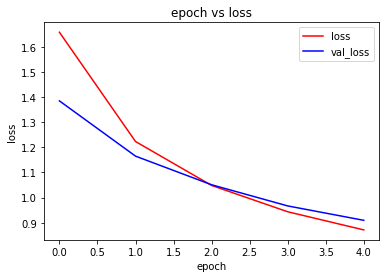

In [84]:
loss = np.array(CNN2.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN2.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
#plt.yscale("Log")
plt.show()

###### 【問題8】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。